<a href="https://colab.research.google.com/github/TheGooseGuy/Insurance-Product-Prediction/blob/main/final_copy_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Stephen Torku, Zikang Ge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV

pd.set_option('display.precision', 2)                     # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation
plt.style.use('seaborn-v0_8')                             # pretty matplotlib plots

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_excel("/content/drive/MyDrive/6100 Project2 DATA/Project2_Training.xlsx")
test = pd.read_excel("/content/drive/MyDrive/6100 Project2 DATA/Project2_Test.xlsx")

In [4]:
train_data = train.copy()
test_data = test.copy()

# Data Pre-Processing

In [5]:
# Rename test data columns to match train data
test_data.rename(columns={
    'ANNUALKM': 'ANNUAL_KM',
    'COMMUTEDISTANCE': 'COMMUTE_DISTANCE',
    'MARKINGSYSTEM': 'MARKING_SYSTEM',
    'TRACKINGSYSTEM': 'TRACKING_SYSTEM',
    'VEHICLEOWNERSHIP': 'VEHICLE_OWNERSHIP',
    'VEHICLEVALUE': 'VEHICLE_VALUE',
    'YEAROFBIRTH': 'YEAR_OF_BIRTH',
    'POSTALCODE': 'POSTAL_CODE',
    'AREACODE': 'AREA_CODE',
    'YEARSLICENSED': 'YEARS_LICENSED',
    'YEARSASPRINCIPALDRIVER': 'YEARS_AS_PRINCIPAL_DRIVER',
    'MULTIPRODUCT': 'MULTI_PRODUCT',
    'MARITALSTATUS': 'MARITAL_STATUS',
    'CONVICTIONCOUNTMINOR3YRS': 'CONVICTION_COUNT_MINOR_3YRS',
    'CONVICTIONCOUNTMAJOR3YRS': 'CONVICTION_COUNT_MAJOR_3YRS',
    'CONVICTIONCOUNTCRIMINAL3YRS': 'CONVICTION_COUNT_CRIMINAL_3YRS',
    'ASSIGNEDLOSSESPD5YRS': 'ASSIGNED_LOSSES_PD_5YRS',
    'SUSPENSIONCOUNT': 'SUSPENSION_COUNT',}, inplace=True)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101891 entries, 0 to 101890
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   QUOTEDATE                       101891 non-null  datetime64[ns]
 1   VEHICLEYEAR                     101891 non-null  int64         
 2   VEHICLEMAKE                     101891 non-null  object        
 3   VEHICLEMODEL                    101891 non-null  object        
 4   ANNUAL_KM                       101890 non-null  float64       
 5   COMMUTE_DISTANCE                66478 non-null   float64       
 6   MARKING_SYSTEM                  25 non-null      object        
 7   TRACKING_SYSTEM                 4 non-null       object        
 8   VEHICLE_OWNERSHIP               25441 non-null   object        
 9   VEHICLE_VALUE                   37218 non-null   float64       
 10  VEHICLEUSE                      101891 non-null  object 

In [7]:
# Combine train data and test data, will split them after data processing.
train_data['is_train'] = 1
test_data['is_train'] = 0

## Drop Duplicates

After observing the dataset, we realized that there were some duplicate columns, since these are redundant, we decided to drop these columns

In [8]:
# Drop duplicate rows in train data (print number of rows)
print(f"Number of rows before dropping duplicates: {train_data.shape[0]}")
train_data = train_data.drop_duplicates()
print(f"Number of rows after dropping duplicates: {train_data.shape[0]}")

Number of rows before dropping duplicates: 101891
Number of rows after dropping duplicates: 101886


## Exploring Numerical columns
In this section, we explored the distributions of the numerical columns and dealt with the outliers accordingly. We did this by generating boxplots for all the columns. Columns which looked like they had extreme outliers were plotted separately below.

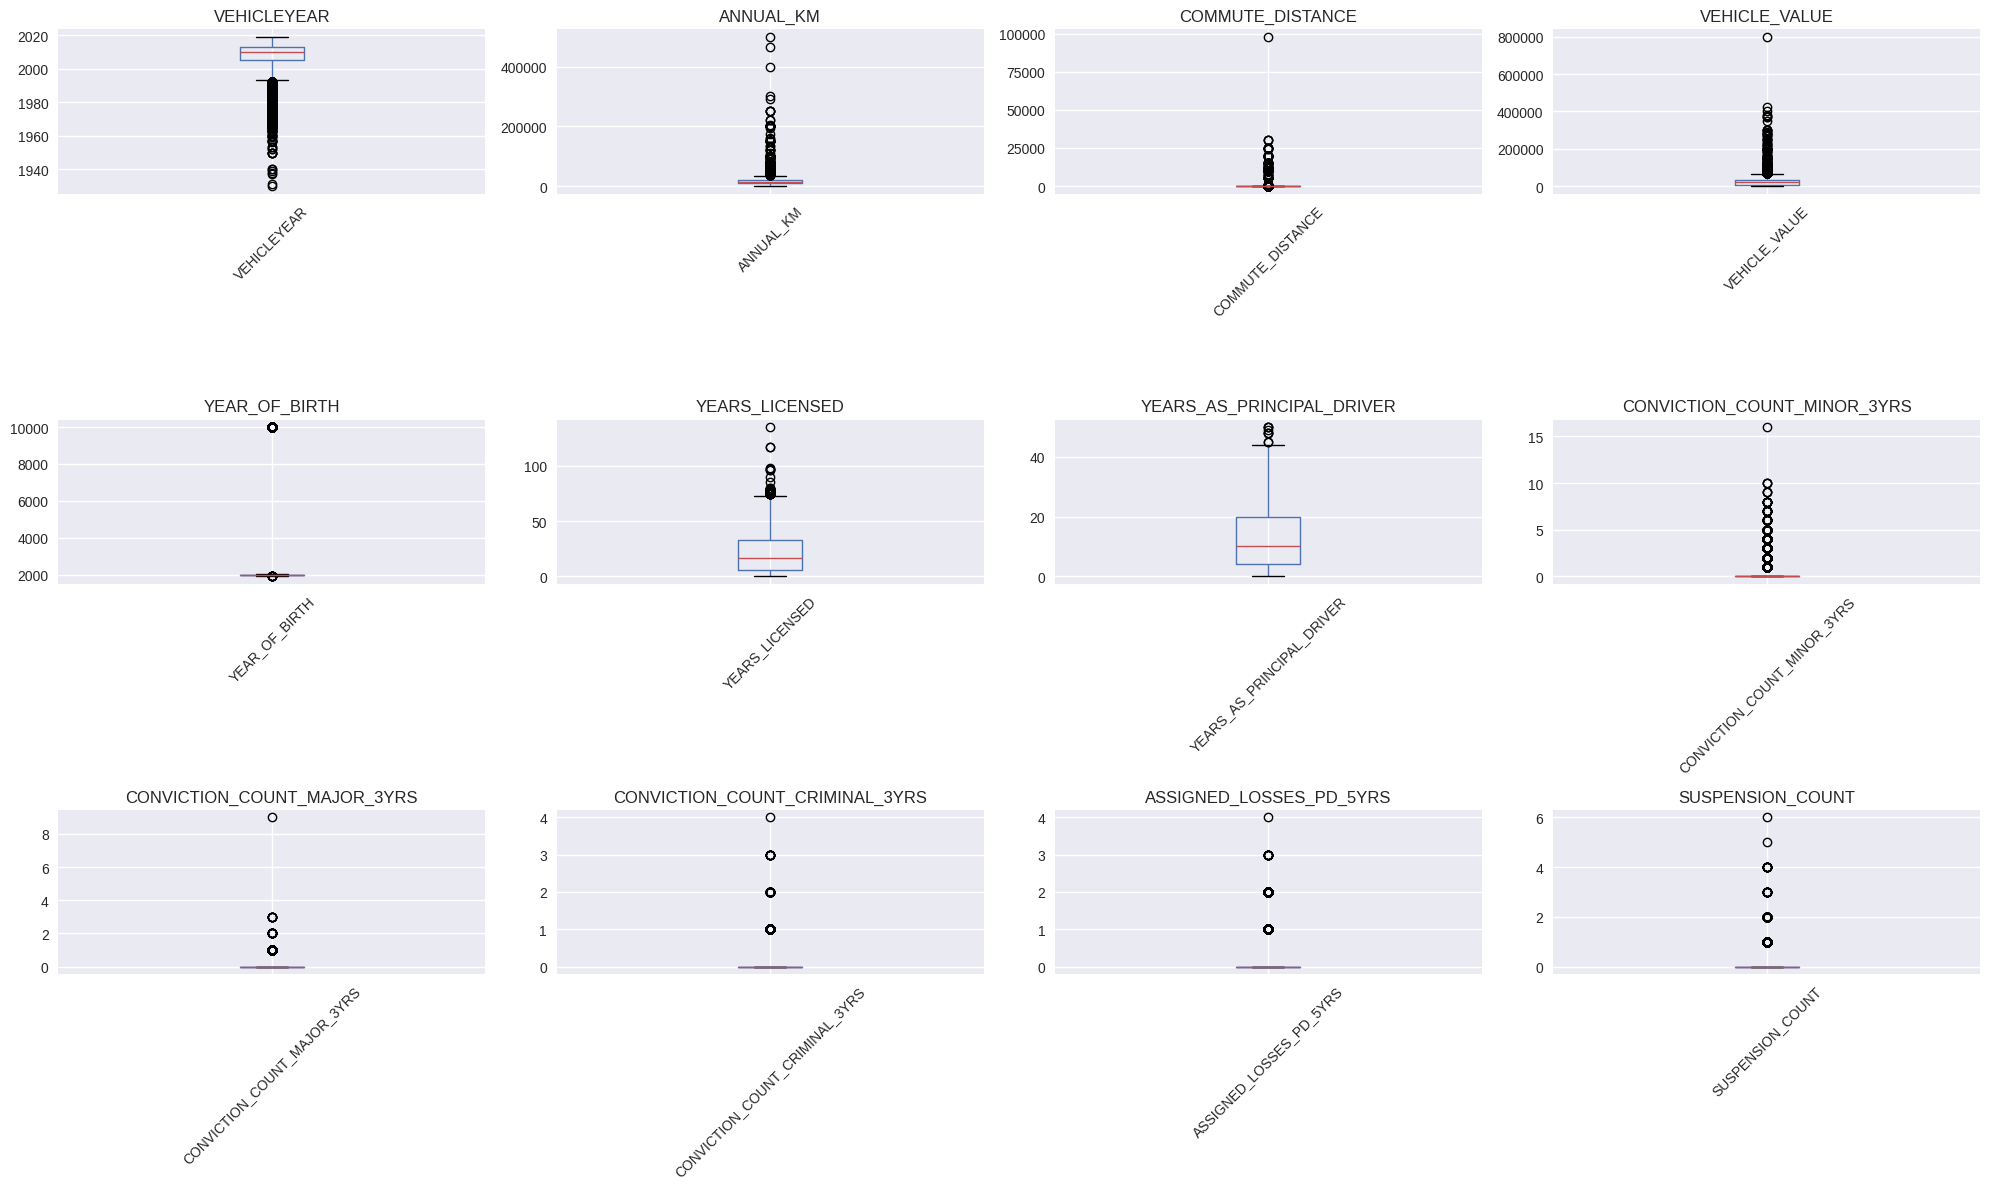

In [9]:
# Plot boxplots

numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

# Increase figure size and layout for better readability
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))  # Adjust rows/cols based on number of columns
axes = axes.flatten()  # Flatten axes array for easy indexing

# Plot boxplots for each column
for i, col in enumerate(numerical_columns):
    if i < len(axes):  # Handle cases where number of columns > subplots
        train_data.boxplot(column=col, ax=axes[i])
        axes[i].set_title(col, fontsize=12)
        axes[i].tick_params(axis='x', labelrotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

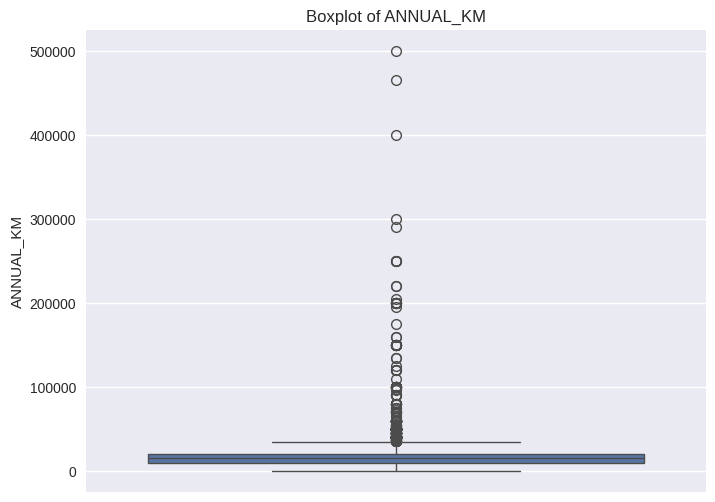

In [10]:
# Boxplot for 'ANNUAL_KM' column
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_data['ANNUAL_KM'])
plt.title('Boxplot of ANNUAL_KM')
plt.show()

In [11]:
# For this column, there were many outliers, however we decided to drop those > 300000 because those were a relatively isolated/ extreme group of outliers
index_to_drop = train_data[train_data['ANNUAL_KM']>300000].index
train_data = train_data.drop(index_to_drop, axis=0)

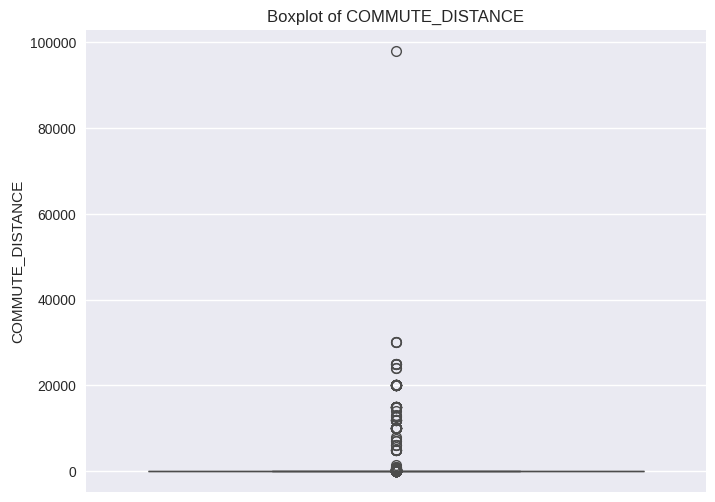

In [12]:
# Boxplot for COMMUTE_DISTANCE
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_data['COMMUTE_DISTANCE'])
plt.title('Boxplot of COMMUTE_DISTANCE')
plt.show()

In [13]:
# For this column, there were many outliers, however we decided to drop those > 20000 because those were a relatively isolated group of outliers
index_to_drop = train_data[train_data['COMMUTE_DISTANCE']>=20000].index
train_df = train_data.drop(index_to_drop, axis=0)

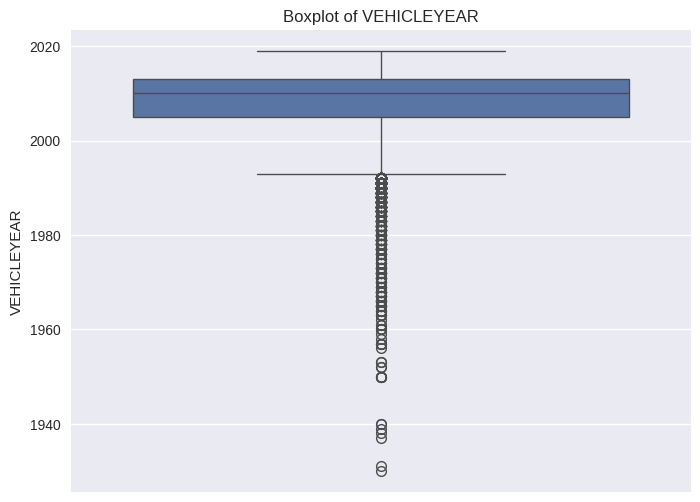

In [14]:
# Boxplot for 'VEHICLEYEAR'
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_data['VEHICLEYEAR'])
plt.title('Boxplot of VEHICLEYEAR')
plt.show()

In [15]:
# For this column, there were many outliers, however we decided to drop those < 1940 because those were a relatively isolated/ extreme group of outliers

index_to_drop = train_data[train_data['VEHICLEYEAR']<1945].index
train_data = train_data.drop(index_to_drop, axis=0)

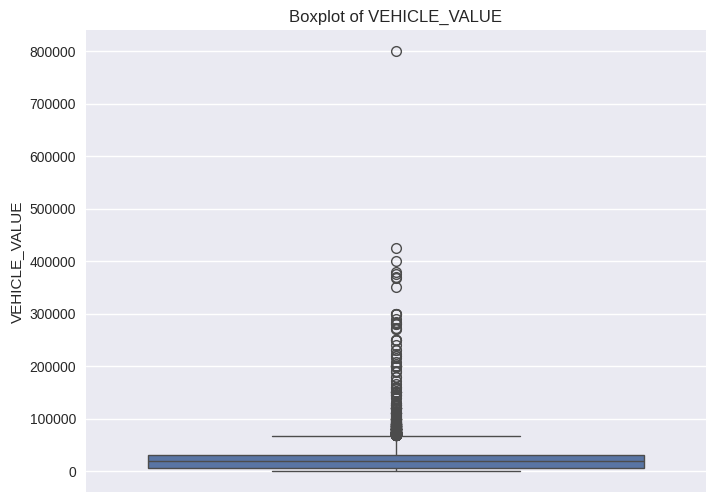

In [16]:
# Boxplot for VEHICLE_VALUE
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_data['VEHICLE_VALUE'])
plt.title('Boxplot of VEHICLE_VALUE')
plt.show()

In [17]:
# For this column, there were many outliers, however we decided to drop those > 300000 because those were a relatively isolated/ extreme group of outliers
index_to_drop = train_data[train_data['VEHICLE_VALUE']>=300000].index
train_data = train_data.drop(index_to_drop, axis=0)

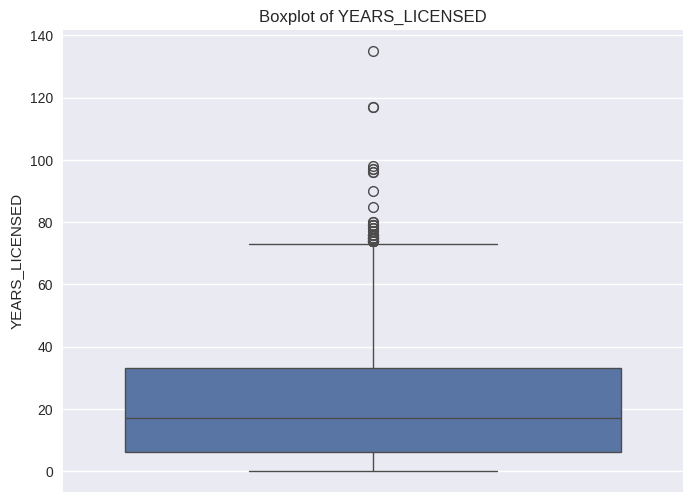

In [18]:
# Boxplot for YEAR_LICENSED
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_data['YEARS_LICENSED'])
plt.title('Boxplot of YEARS_LICENSED')
plt.show()

In [19]:
# For this column, there were many outliers, however we decided to drop those > 80 because those were a relatively isolated/ extreme group of outliers
index_to_drop = train_data[train_data['YEARS_LICENSED']>=80].index
train_data = train_data.drop(index_to_drop, axis=0)

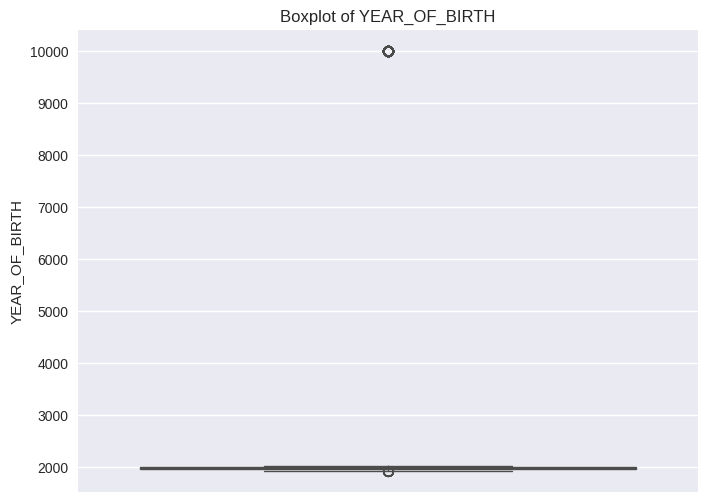

In [20]:
# Boxplot for YEAR_OF_BIRTH
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_data['YEAR_OF_BIRTH'])
plt.title('Boxplot of YEAR_OF_BIRTH')
plt.show()

In [21]:
# For this column, we decided to drop 9999 because it did not make sense and was an obvious error
index_to_drop = train_data[(train_data['YEAR_OF_BIRTH']==9999)].index
train_data = train_data.drop(index_to_drop, axis=0)

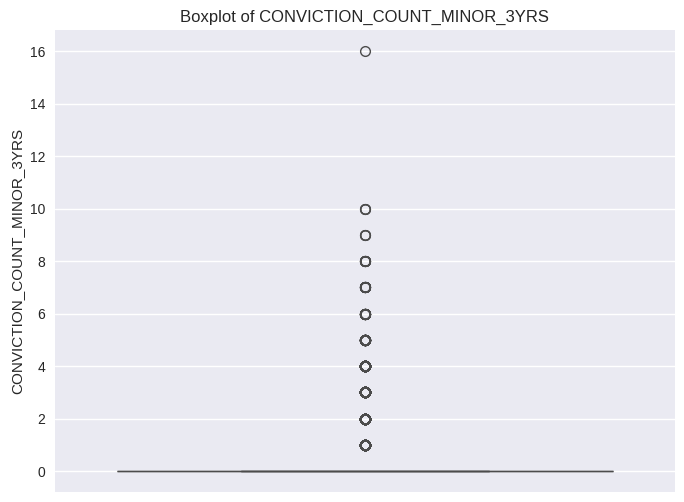

In [22]:
# Boxplot for CONVICTION_COUNT_MINOR_3YRS
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_data['CONVICTION_COUNT_MINOR_3YRS'])
plt.title('Boxplot of CONVICTION_COUNT_MINOR_3YRS')
plt.show()

In [23]:
# For this column, we decided to drop the row with value > 10 because it was a relatively isolated/ extreme  outlier
index_to_drop = train_data[(train_data['CONVICTION_COUNT_MINOR_3YRS']>10)].index
train_data = train_data.drop(index_to_drop, axis=0)

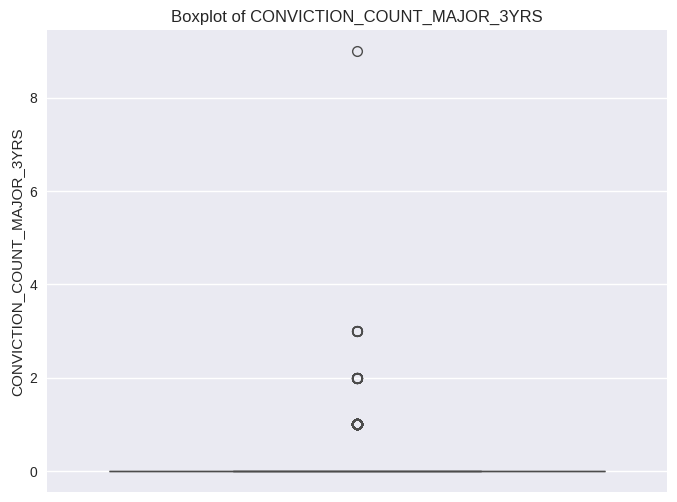

In [24]:
# Boxplot for CONVICTION_COUNT_MAJOR_3YRS
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_data['CONVICTION_COUNT_MAJOR_3YRS'])
plt.title('Boxplot of CONVICTION_COUNT_MAJOR_3YRS')
plt.show()

In [25]:
# For this column, we decided to drop the row with value > 4 because it was a relatively isolated/ extreme  outlier
index_to_drop = train_data[(train_data['CONVICTION_COUNT_MINOR_3YRS']>4)].index
train_data = train_data.drop(index_to_drop, axis=0)

In [26]:
# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)
combined_data.head()

,QUOTEDATE,VEHICLEYEAR,VEHICLEMAKE,VEHICLEMODEL,ANNUAL_KM,COMMUTE_DISTANCE,MARKING_SYSTEM,TRACKING_SYSTEM,VEHICLE_OWNERSHIP,VEHICLE_VALUE,...,MULTI_PRODUCT,MARITAL_STATUS,OCCUPATION,CONVICTION_COUNT_MINOR_3YRS,CONVICTION_COUNT_MAJOR_3YRS,CONVICTION_COUNT_CRIMINAL_3YRS,ASSIGNED_LOSSES_PD_5YRS,SUSPENSION_COUNT,IS_BOUND,is_train
0,2016-01-02,2006,VOLKSWAGEN,JETTA 2.5 4P,"10,000.00",NaN,NaN,NaN,Owned,"3,000.00",...,No,Married,Trades,0,0,0,0,0,0.00,1
1,2016-01-02,2017,HYUNDAI,ELANTRA GL 4DR,"20,000.00",NaN,NaN,NaN,Owned,1.00,...,No,Married,Not Known,0,0,0,0,0,0.00,1
2,2016-01-02,2015,CHEVROLET TRUCK/VAN,SILVERADO 2500 HD LT CREW CAB 4WD,"15,000.00",NaN,NaN,NaN,NaN,NaN,...,No,Single,Not Known,0,0,0,0,0,0.00,1
3,2016-01-02,2010,TOYOTA,COROLLA CE 4DR,"20,000.00",20.00,NaN,NaN,NaN,NaN,...,Yes,Single,Not Known,0,0,0,0,0,0.00,1
4,2016-01-04,2013,HONDA,CIVIC LX 4DR,"30,000.00",30.00,NaN,NaN,NaN,NaN,...,Yes,Single,Not Known,0,0,0,0,0,0.00,1


In [27]:
# Check for NA values in each column
for column in combined_data.columns:
    if combined_data[column].isna().sum() > 0:
        print(f"{column} has {combined_data[column].isna().sum()} missing values.")

ANNUAL_KM has 1 missing values.
COMMUTE_DISTANCE has 40409 missing values.
MARKING_SYSTEM has 116416 missing values.
TRACKING_SYSTEM has 116454 missing values.
VEHICLE_OWNERSHIP has 87521 missing values.
VEHICLE_VALUE has 74490 missing values.
YEARS_LICENSED has 11 missing values.
YEARS_AS_PRINCIPAL_DRIVER has 115680 missing values.
IS_BOUND has 15114 missing values.


In [28]:
# Dropping Columns With Over 100k Missing Values
combined_data.drop(columns=['YEARS_AS_PRINCIPAL_DRIVER', 'TRACKING_SYSTEM','MARKING_SYSTEM'], axis =1, inplace=True)
combined_data.head()

,QUOTEDATE,VEHICLEYEAR,VEHICLEMAKE,VEHICLEMODEL,ANNUAL_KM,COMMUTE_DISTANCE,VEHICLE_OWNERSHIP,VEHICLE_VALUE,VEHICLEUSE,GENDER,...,MULTI_PRODUCT,MARITAL_STATUS,OCCUPATION,CONVICTION_COUNT_MINOR_3YRS,CONVICTION_COUNT_MAJOR_3YRS,CONVICTION_COUNT_CRIMINAL_3YRS,ASSIGNED_LOSSES_PD_5YRS,SUSPENSION_COUNT,IS_BOUND,is_train
0,2016-01-02,2006,VOLKSWAGEN,JETTA 2.5 4P,"10,000.00",NaN,Owned,"3,000.00",Pleasure,Male,...,No,Married,Trades,0,0,0,0,0,0.00,1
1,2016-01-02,2017,HYUNDAI,ELANTRA GL 4DR,"20,000.00",NaN,Owned,1.00,Business,Male,...,No,Married,Not Known,0,0,0,0,0,0.00,1
2,2016-01-02,2015,CHEVROLET TRUCK/VAN,SILVERADO 2500 HD LT CREW CAB 4WD,"15,000.00",NaN,NaN,NaN,Pleasure,Male,...,No,Single,Not Known,0,0,0,0,0,0.00,1
3,2016-01-02,2010,TOYOTA,COROLLA CE 4DR,"20,000.00",20.00,NaN,NaN,Commute,Male,...,Yes,Single,Not Known,0,0,0,0,0,0.00,1
4,2016-01-04,2013,HONDA,CIVIC LX 4DR,"30,000.00",30.00,NaN,NaN,Commute,Male,...,Yes,Single,Not Known,0,0,0,0,0,0.00,1


## Imputing and Getting Dummy Variables

In [29]:
# QUOTEDATE
# Created a new column called season using the quote date column, and then dropped the quote date column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

combined_data['Season'] = combined_data['QUOTEDATE'].apply(get_season)

combined_data = combined_data.drop(columns=['QUOTEDATE']) # Drop QUOTEDATE as no longer needed

In [30]:
# ANNUAL_KM
# Imputed missing values with median
combined_data['ANNUAL_KM'].fillna(combined_data['ANNUAL_KM'].median(), inplace=True)

<ipython-input-30-add11dd679c0>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['ANNUAL_KM'].fillna(combined_data['ANNUAL_KM'].median(), inplace=True)


In [34]:
# COMMUTE DISTANCE
# Imputed missing values with median
combined_data['COMMUTE_DISTANCE'].fillna(train_data['COMMUTE_DISTANCE'].median(), inplace=True)

<ipython-input-34-0f0c1933c1ff>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['COMMUTE_DISTANCE'].fillna(train_data['COMMUTE_DISTANCE'].median(), inplace=True)


In [35]:
# VEHICLE_OWNERSHIP
combined_data['VEHICLE_OWNERSHIP'].fillna(train_data['VEHICLE_OWNERSHIP'].mode()[0], inplace=True) # Fill with "Owned"

<ipython-input-35-baac7bf8e5cd>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['VEHICLE_OWNERSHIP'].fillna(train_data['VEHICLE_OWNERSHIP'].mode()[0], inplace=True) # Fill with "Owned"


In [36]:
# VEHICLE VALUE

# Filling missing values of vehicle value with median vehicle value of each vehicle make
combined_data['VEHICLE_VALUE'] = combined_data.groupby('VEHICLEMAKE')['VEHICLE_VALUE'].transform(lambda value: value.fillna(value.median()))


combined_data['VEHICLE_VALUE'] = combined_data['VEHICLE_VALUE'].fillna(combined_data['VEHICLE_VALUE'].median())

In [37]:
# Filling missing values of years licensed with median years licensed of each year_of_birth

combined_data['YEARS_LICENSED'] = combined_data.groupby('YEAR_OF_BIRTH')['YEARS_LICENSED'].transform(lambda value: value.fillna(value.median()))

In [38]:
# DROPPING VEHICLE MODEL COLUMN SINCE THE MAJORITY OF THE VALUES ARE NOT CONTEXTUALLY USEFUL
combined_data['VEHICLEMODEL'].value_counts()
combined_data.drop(columns=['VEHICLEMODEL'], axis =1, inplace=True)

In [39]:
# Vehicle Make
distinct_vehicle_makes = combined_data['VEHICLEMAKE'].unique()
print(len(distinct_vehicle_makes))

278


In [40]:
# Using regex to combine similar names, correct typos and remove values that made no sense
# ChatGPT helped us with this
replacements = {
  # Volkswagen variations
  r'\bVW\b|\bWV\b|\bVOLKS\b|VOLKSWAGON|VOLGSWAGEN|VOLSWAGEN|VOLKSWAGENJAVASCRIPT:VOID\(0\)|VOLLKS|VOLKSWAGEN(?:\s+TRUCK/VAN|\s+CAMION/VA)?': 'VOLKSWAGEN',

  # Honda variations
  r'HONDA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|HONODA|HONDA \s*CIVIC|HONDA \s*ACCORD|HONDA \s*CR-\s*V|HONDA \s*650|CIVIC': 'HONDA',

  # Ford variations
  r'\bFORD\b|\bF150\b|\bF250\b|FORD \s*150|FORD \s*FOCUS|FORD \s*EDGE|FORD \s*MUSTANG|FORD(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|RANGER|MUSTANG': 'FORD',

  # Dodge/Ram variations
  r'RAM|DODGE|DOGDE|DODGE/RAM(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|DODGE \s*RAM|DODGE \s*GRAND \s*CARAVAN|GRAND \s*CARAVAN|CHALLENGER|DODDGE': 'DODGE',

  # Chevrolet variations
  r'\bCHEV\b|CHEVY|CHEVROLET(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|CHEVROLER|CHEVROLE|CHEVROELT|CHERVOLET|CEVROLET|CHEVRELOT|CORVETTE|EL \s*CAMINO|ASTRO|MAILBOU|Z28|SPRINT': 'CHEVROLET',

  # Toyota variations
  r'TOYOTA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|TOYOATA|TOYOTO|TOTOTA|TOYTO|CORROLLA|COROLLA|CAMRY|CELICA|MATRIX|TOYOTA \s*HIGHLANDER': 'TOYOTA',

  # Mercedes variations
  r'MERCEDES \s*BENZ|MERCEDEZ \s*BENZ|MECEDEZ|MERCEDES-BENZ(?:\s+TRUCK)?|MERCEDES|E350|MERZ': 'MERCEDES-BENZ',

  # Chrysler variations
  r'CHYRSLER|CHRYSLER(?:\s+TRUCK/VAN)?|CRYSLER|CHRYLSER|CHRSYLER': 'CHRYSLER',

  # Nissan variations
  r'NISSIAN|NISSAN(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|NISSSAN|NISASN|ALTIMA|NISAN': 'NISSAN',

  # Pontiac variations
  r'PONTIAC(?:\s+TRUCK/VAN)?|PONTAIC|PONTIIAC|POTIAC|PONITAC': 'PONTIAC',

  # Mazda variations
  r'MAZDA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|MADZA|MAZDS|MAZDA3|MAZDA \s*3': 'MAZDA',

  # Hyundai variations
  r'HYUNDAI(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|HYNDAI|HYUNDIA|HUNDAY|HUNDAI|HYNDEI|HYUANDAI|ELANTRA|ELANTRA \s*GT': 'HYUNDAI',

  # Infiniti variations
  r'INFINITY|INFINTI|INFINITI(?:\s+TRUCK/VAN)?': 'INFINITI',

  # Porsche variations
  r'PORCHE|PROSCHE|PORSCHE(?:\s+TRUCK/VAN)?': 'PORSCHE',

  # Land Rover variations
  r'LANDROVER|RANGE \s*ROVER|ROVER|LAND \s*ROVER': 'LAND ROVER',

  # Acura variations
  r'ACCURA|ACURA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?': 'ACURA',

  # BMW variations
  r'BMW(?:\s+TRUCK/VAN)?': 'BMW',

  # Cadillac variations
  r'CADILLAC(?:\s+TRUCK/VAN)?|CADILLIAC': 'CADILLAC',

  # GMC variations
  r'GMC(?:\s+TRUCK/VAN)?|GMC \s*RALLY|SIERRA \s*2500': 'GMC',

  # Other major manufacturers
  r'BUICK(?:\s+TRUCK/VAN)?': 'BUICK',
  r'JEEP|JEPP|JEEP \s*WRANGLER': 'JEEP',
  r'SUBARU(?:\s+TRUCK/VAN)?': 'SUBARU',
  r'VOLVO(?:\s+TRUCK/VAN)?': 'VOLVO',
  r'KIA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?': 'KIA',
  r'LINCOLN(?:\s+TRUCK/VAN)?': 'LINCOLN',
  r'LEXUS(?:\s+TRUCK/VAN|\s+CAMION/VAN)?': 'LEXUS',
  r'MERCURY(?:\s+TRUCK/VAN)?': 'MERCURY',
  r'SATURN(?:\s+TRUCK/VAN)?|VUE': 'SATURN',
  r'OLDSMOBILE(?:\s+TRUCK/VAN)?|CUTLASS': 'OLDSMOBILE',
  r'AUDI(?:\s+TRUCK/VAN)?': 'AUDI',
  r'MINI(?:\s+COOPER)?': 'MINI',
  r'SCION': 'SCION',
  r'SUZUKI(?:\s+TRUCK/VAN)?': 'SUZUKI',

  # Luxury/Exotic Brands
  r'MASERATI|MAZERATI': 'MASERATI',
  r'BENTLEY': 'BENTLEY',
  r'LAMBORGHINI|DIABLO': 'LAMBORGHINI',
  r'FERRARI': 'FERRARI',
  r'ALFA|ALFA \s*ROMEO': 'ALFA ROMEO',
  r'ASTON \s*MARTIN': 'ASTON MARTIN',
  r'ROLLS \s*ROYCE': 'ROLLS ROYCE',
  r'MCLAREN': 'MCLAREN',

  # Electric/Modern
  r'TESLA(?:\s+TRUCK/VAN)?': 'TESLA',
  r'FISKER': 'FISKER',

  # Discontinued/Classic
  r'PLYMOUTH(?:\s+TRUCK/VAN)?|PLYMONTH': 'PLYMOUTH',
  r'SAAB': 'SAAB',
  r'JAGUAR(?:\s+TRUCK/VAN)?': 'JAGUAR',
  r'SMART': 'SMART',
  r'DATSUN': 'DATSUN',
  r'MG|MGB|MGA': 'MG',
  r'HUMMER': 'HUMMER',
  r'GEO(?:\s+TRUCK/VAN)?': 'GEO',
  r'EAGLE': 'EAGLE',
  r'DAEWOO': 'DAEWOO',
  r'DIHATSU': 'DAIHATSU',

  # Commercial/Other
  r'KENWORTH': 'KENWORTH',
  r'FREIGHTLINER': 'FREIGHTLINER',
  r'HINO': 'HINO',
  r'INTERNATIONAL': 'INTERNATIONAL',
  r'AM \s*GENERAL': 'AM GENERAL',
  r'YAMAHA': 'YAMAHA',
  r'UNITED': 'UNITED',
  r'ROYAL': 'ROYAL',
  r'MONICO': 'MONACO',

  # Motorcycles/Recreational
  r'HARLEY|HARLEY \s*DAVIDSON|STREET \s*GLIDE \s*SPECIAL': 'HARLEY DAVIDSON',
  r'ARCTIC \s*CAT|ARTCIT \s*CAT|ARTIC \s*CAT': 'ARCTIC CAT',
  r'BOMBARDIER|BOMBADIER|SKI-DOO|SKIDOO': 'BOMBARDIER',
  r'KTM': 'KTM',
  r'KABUTO': 'KABUTO',
  r'SCOOTTERRE': 'SCOOTTERRE',

  # Generic/Unknown
  r'CAR': 'Unknown',
  r'UNDISCLOSED': 'Unknown',
  r'CONVERTED': 'Unknown',
  r'2XXXXXXXXXXXXXXXXXX': 'Unknown',


  # Non-specific Truck/Van entries
  r'(?:TRUCK|VAN|CAMION)': '',  # These should be removed or handled separately

  # Regional Variations
  r'GMC \s*CAMION/VAN': 'GMC',
  r'TOYOTA \s*CAMION/VAN': 'TOYOTA',
  r'HONDA \s*CAMION/VAN': 'HONDA',
  r'MAZDA \s*CAMION/VAN': 'MAZDA',
  r'VOLKSWAGEN \s*CAMION/VA': 'VOLKSWAGEN',
  r'MITSUBISHI \s*CAMION/VA': 'MITSUBISHI',

  # Clean up specific patterns
  r'/.*$': '',  # Remove anything after a forward slash
  r'\s+': ' ',  # Standardize spaces
  r'^\s|\s$': ''  # Remove leading/trailing spaces
}

combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].str.upper().str.strip()

# Apply all replacements in place
combined_data['VEHICLEMAKE'].replace(replacements, regex=True, inplace=True)

# Final cleanup in place
combined_data['VEHICLEMAKE'] = (combined_data['VEHICLEMAKE']
                           .str.strip()
                           .str.replace(r'\s+', ' ', regex=True)  # Standardize spaces
                           .str.replace(r'/.*$', '', regex=True)  # Remove anything after /
                           )

# First, apply upper case and strip whitespace
combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].str.upper().str.strip()

# Apply regex replacements iteratively in a simplified form
for pattern, replacement in replacements.items():
    combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].str.replace(pattern, replacement, regex=True)

# Additional cleanup to standardize spaces and remove trailing info
combined_data['VEHICLEMAKE'] = (combined_data['VEHICLEMAKE']
                                .str.replace(r'\s+', ' ', regex=True)  # Standardize spaces
                                .str.replace(r'/.*$', '', regex=True)  # Remove anything after /
                                .str.strip())  # Remove leading/trailing spaces

# Grouping less common makes
threshold = 100  # Example threshold for frequency
top_makes = combined_data['VEHICLEMAKE'].value_counts()[combined_data['VEHICLEMAKE'].value_counts() > threshold].index
combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].apply(lambda x: x if x in top_makes else 'Other')

<ipython-input-40-de915be37737>:150: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['VEHICLEMAKE'].replace(replacements, regex=True, inplace=True)


In [42]:
categorical_columns = combined_data.select_dtypes(include='object').columns
combined_data[categorical_columns] = combined_data[categorical_columns].astype(str)

In [43]:
# Dummy variables
combined_data = pd.get_dummies(combined_data, drop_first=True)

In [45]:

numerical_columns = list(combined_data.select_dtypes(include=['float64', 'int64']).columns)

numerical_columns.remove('IS_BOUND')
numerical_columns.remove('is_train')
numerical_columns

['VEHICLEYEAR',
 'ANNUAL_KM',
 'COMMUTE_DISTANCE',
 'VEHICLE_VALUE',
 'YEAR_OF_BIRTH',
 'YEARS_LICENSED',
 'CONVICTION_COUNT_MINOR_3YRS',
 'CONVICTION_COUNT_MAJOR_3YRS',
 'CONVICTION_COUNT_CRIMINAL_3YRS',
 'ASSIGNED_LOSSES_PD_5YRS',
 'SUSPENSION_COUNT']

In [46]:
# Standardizing numerical columns
scaler = StandardScaler()

combined_data[numerical_columns] = scaler.fit_transform(combined_data[numerical_columns])

combined_data.head()

,VEHICLEYEAR,ANNUAL_KM,COMMUTE_DISTANCE,VEHICLE_VALUE,YEAR_OF_BIRTH,YEARS_LICENSED,CONVICTION_COUNT_MINOR_3YRS,CONVICTION_COUNT_MAJOR_3YRS,CONVICTION_COUNT_CRIMINAL_3YRS,ASSIGNED_LOSSES_PD_5YRS,...,OCCUPATION_Professional/Health,OCCUPATION_Professional/Other,OCCUPATION_Professional/Social,OCCUPATION_Retired,OCCUPATION_Sales,OCCUPATION_Service Work,OCCUPATION_Student,OCCUPATION_Trades,OCCUPATION_Tradesman,OCCUPATION_Unemployed
0,-0.51,-0.60,-0.04,-1.42,-0.01,0.26,-0.33,-0.05,-0.07,-0.24,...,False,False,False,False,False,False,False,True,False,False
1,1.39,0.62,-0.04,-1.66,-0.13,-0.66,-0.33,-0.05,-0.07,-0.24,...,False,False,False,False,False,False,False,False,False,False
2,1.04,0.01,-0.04,0.07,-0.12,1.13,-0.33,-0.05,-0.07,-0.24,...,False,False,False,False,False,False,False,False,False,False
3,0.18,0.62,-0.02,-0.40,0.07,-1.09,-0.33,-0.05,-0.07,-0.24,...,False,False,False,False,False,False,False,False,False,False
4,0.70,1.84,-0.00,-0.24,0.04,-1.16,-0.33,-0.05,-0.07,-0.24,...,False,False,False,False,False,False,False,False,False,False


In [47]:
# Split combined data back to train data and test data
train_data = combined_data[combined_data['is_train'] == 1].drop(columns=['is_train'])
test_data = combined_data[combined_data['is_train'] == 0].drop(columns=['is_train', 'IS_BOUND'])

# Random Forest

In [48]:
X = train_data.drop('IS_BOUND', axis=1)
y = train_data['IS_BOUND']

## Fitting A Random Forest Classifier model and plotting ROC curve

 In this section, we fit the model using the train plit and then plot the ROC curve which represents the tradeoff between the true positive rate and the false positive rate for predictions

Accuracy: 0.7785397138628515


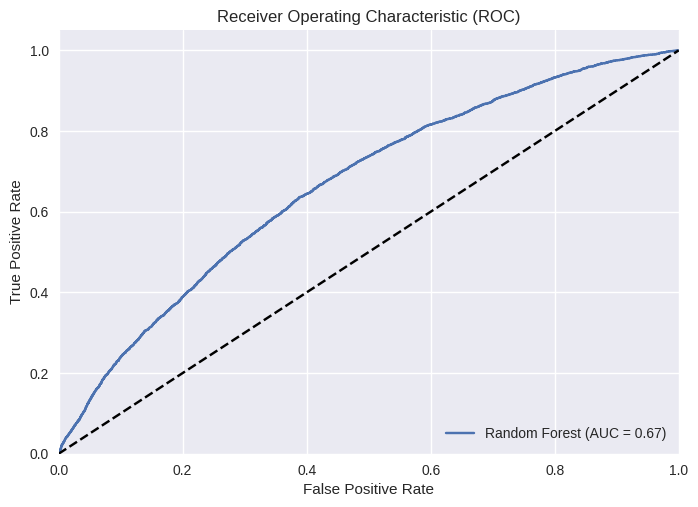

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split data with important features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a new RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split=5, min_samples_leaf=1, max_depth=10)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate ROC curve and AUC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Model Tunning

### Hyperparameter Tuning
In this section, we use RandomizedSearchCV to find the best hyperparameters of a Random Forest model based on a custom scoring function (revenue_score) that calculates revenue. We then retrieve the best model found from this. RandomizedSearchCV was used over GridSearchCV mainly because this was relatively faster to run.

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer


def revenue_score(y_true, y_pred):
    # Calculate confusion matrix components
    tp = np.sum((y_true == 1) & (y_pred == 1))  # True Positives
    fp = np.sum((y_true == 0) & (y_pred == 1))  # False Positives

    # Calculate revenue
    revenue = (5.5 * tp) - (1 * (tp + fp))
    return revenue
revenue_scorer = make_scorer(revenue_score, greater_is_better=True)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomizedSearchCV object
# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring=revenue_scorer,  # Use custom scorer
    n_jobs=-1,
    random_state=42
)


# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Use the best model for prediction
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
final_revenue = revenue_score(y_test, y_pred)
print("Final Revenue:", final_revenue)

Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best score: 422.3
Final Revenue: 646.5


### Threshold Adjustment

In this section, we evaluate the model's performance across different probability thresholds by calculating false positive rates (FPR), false negative rates (FNR), and revenue at each threshold. We plot all these against the probability thresholds. We then choose the threshold where FNR = FPR since we are interested in balacing these and not only interested in maximizing revenue

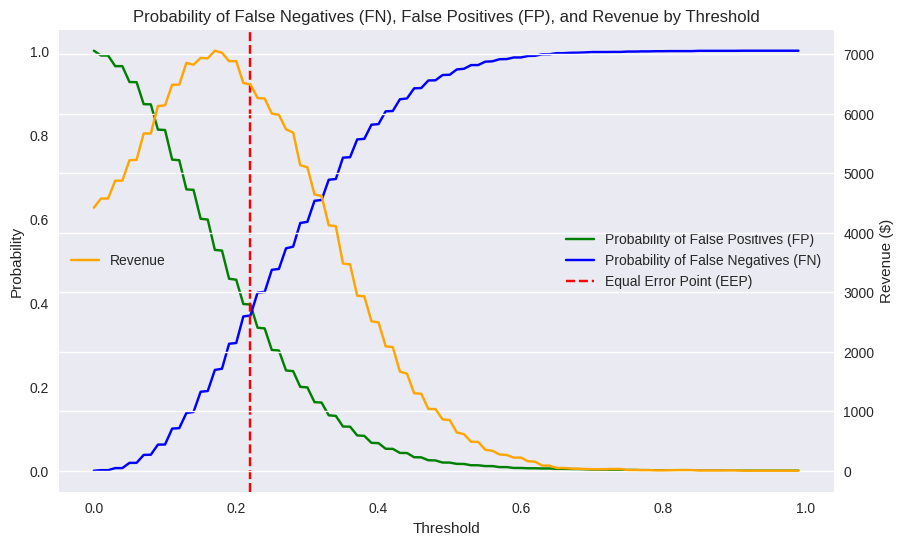

Equal Error Point (EEP) Threshold: 0.22


In [55]:
# ChatGPT helped us with this
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict probabilities for the positive class
y_probs = best_rf_model.predict_proba(X_test)[:, 1]

# Define a range of thresholds
thresholds = np.arange(0.0, 1.0, 0.01)
false_positive_rates = []
false_negative_rates = []
revenues = []

# Calculate FPR, FNR, and revenue for each threshold
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test[:len(y_pred)], y_pred).ravel()

    # Calculate false positive rate and false negative rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Append FPR and FNR to lists
    false_positive_rates.append(fpr)
    false_negative_rates.append(fnr)

    # Calculate revenue: (5.5 * True Positives) - (1 * Predicted Positives)
    revenue = (5.5 * tp) - (1 * (tp + fp))
    revenues.append(revenue)

# Plotting FPR and FNR against thresholds
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot false positive and false negative rates
ax1.plot(thresholds, false_positive_rates, label="Probability of False Positives (FP)", color="green")
ax1.plot(thresholds, false_negative_rates, label="Probability of False Negatives (FN)", color="blue")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Probability")
ax1.set_title("Probability of False Negatives (FN), False Positives (FP), and Revenue by Threshold")
ax1.grid()
ax1.legend(loc="upper left")

# Plot revenue on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(thresholds, revenues, label="Revenue", color="orange")
ax2.set_ylabel("Revenue ($)")
ax2.legend(loc="center left")

# Mark the Equal Error Point (EEP) where FP and FN rates intersect
equal_error_point = thresholds[np.argmin(np.abs(np.array(false_positive_rates) - np.array(false_negative_rates)))]
ax1.axvline(equal_error_point, color="red", linestyle="--", label="Equal Error Point (EEP)")
ax1.legend(loc="center right")

plt.show()

print(f"Equal Error Point (EEP) Threshold: {equal_error_point}")

## Final Model

In this section, we use the best model we obtained from the hyperparameter tuning, and the threshold from before, to predict the outcomes of the test dataset. On the leaderboard, this model obtained a revenue of 17.

In [56]:
# Align test data columns with training data
test_data = test_data.reindex(columns=X.columns, fill_value=0)

# Get probabilities for the positive class (ISBOUND=1)
probabilities = best_rf_model.predict_proba(test_data)[:, 1]

# Apply the EEP threshold
threshold = 0.22
predictions = (probabilities >= threshold).astype(int)

# Convert predictions to a list
list_predictions = predictions.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]

# Output predictions
print("Predictions:", rounded_list_predictions)
print("Number of predictions:", len(rounded_list_predictions))

Predictions: [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,

# Logistic Regression

Accuracy: 0.592945239269857
Confusion Matrix:
 [[9220 6599]
 [1652 2799]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.58      0.69     15819
         1.0       0.30      0.63      0.40      4451

    accuracy                           0.59     20270
   macro avg       0.57      0.61      0.55     20270
weighted avg       0.73      0.59      0.63     20270

AUC-ROC Score: 0.6446203470400788
F1 Score: 0.404216910968301
Profit: 5996.5


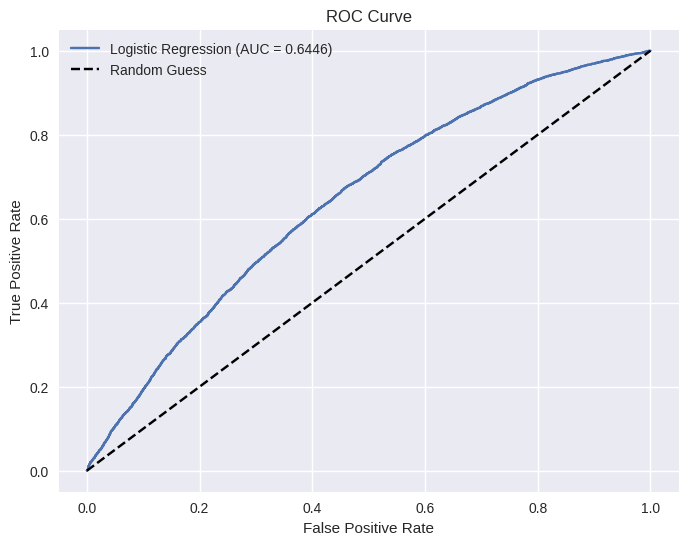

In [57]:
X = train_data.drop(columns=['IS_BOUND'])
y = train_data['IS_BOUND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Prediction

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities

# Calculate ROC curve values: FPR, TPR, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Calculate AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_proba)
print("AUC-ROC Score:", auc_score)
# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
TN, FP = confusion_matrix(y_test, y_pred)[0]
FN, TP = confusion_matrix(y_test, y_pred)[1]
profit = TP * 5.5 + (FP + TP) * -1
print(f"Profit: {profit}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Model Tuning

In [58]:
def log_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
    model = LogisticRegression(class_weight="balanced", penalty='l2', random_state=89, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]


    matrix = confusion_matrix(y_test, y_pred)
    accuracyScore = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    TN, FP = matrix[0]
    FN, TP = matrix[1]
    profit = (TP * 5.5 + (FP + TP) * -1) / len(y_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Average Profit: {profit}")


    y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities

    # Calculate ROC curve values: FPR, TPR, and threshold values
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    # Calculate AUC (Area Under the Curve)
    auc_score = roc_auc_score(y_test, y_proba)
    print("AUC-ROC Score:", auc_score)
    # Calculate F1 Score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for random guess
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return accuracyScore, auc_score, f1, profit

### Class Resampling

In [59]:
# Apply SMOTE and Edited Nearest Neighbors (SMOTEENN)
X = train_data.drop(columns=['IS_BOUND'])
y = train_data['IS_BOUND']
smoteenn = SMOTEENN()
X_resampled, y_resampled = smoteenn.fit_resample(X, y)

Accuracy: 0.8385212965443343
Confusion Matrix:
 [[ 4069   415]
 [ 2599 11582]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.91      0.73      4484
         1.0       0.97      0.82      0.88     14181

    accuracy                           0.84     18665
   macro avg       0.79      0.86      0.81     18665
weighted avg       0.88      0.84      0.85     18665

Average Profit: 2.7701044736137157
AUC-ROC Score: 0.9298543628094557
F1 Score: 0.8848651539460616


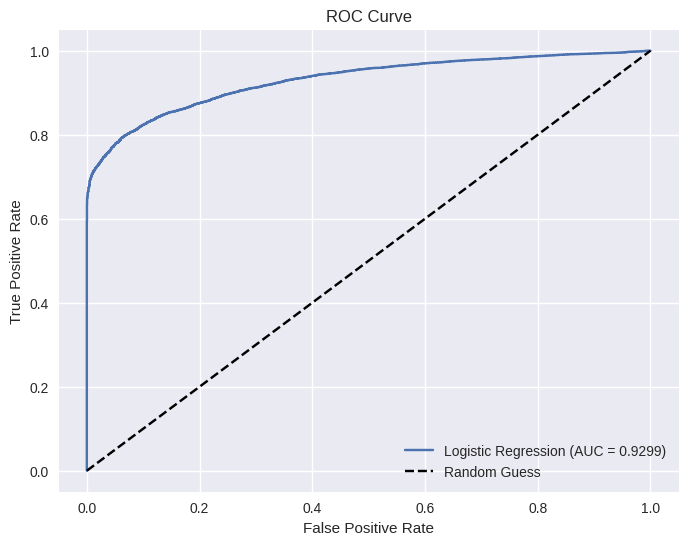

(0.8385212965443343,
 0.9298543628094557,
 0.8848651539460616,
 2.7701044736137157)

In [60]:
log_reg(X_resampled, y_resampled)

### Hyperparameter Tuning

In [61]:
#ChatGPT helped with this
# Trying to find the best hyperparameter value of C in logistic regression model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score

X = X_resampled
y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000]}  # You can extend or modify this range

# Create a Logistic Regression model
log_reg = LogisticRegression(class_weight="balanced", penalty='l2', random_state=89, max_iter=1000)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best C value and corresponding model
best_C = grid_search.best_params_['C']
print(f"Best C Value: {best_C}")

Best C Value: 10


### Threshold

to do: this part should be changed to base on the false negative and false positive rate, then find the threshold

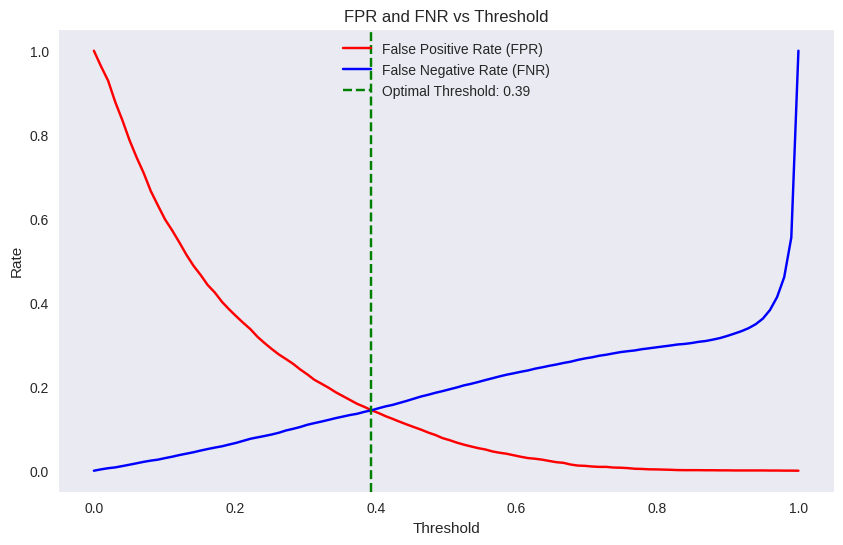

Optimal Threshold: 0.39


In [62]:
X = X_resampled
y = y_resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(C=best_C, class_weight="balanced", penalty='l2', random_state=89, max_iter=1000)
model.fit(X_train, y_train)

# Generate predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Initialize lists to store FPR and FNR
thresholds = np.linspace(0, 1, 100)  # Thresholds from 0 to 1
fpr_list = []
fnr_list = []

# Calculate FPR and FNR for each threshold
for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

    fpr_list.append(fpr)
    fnr_list.append(fnr)

# Find the threshold where FPR and FNR are low and closest to each other
optimal_index = np.argmin(np.abs(np.array(fpr_list) - np.array(fnr_list)))
optimal_threshold = thresholds[optimal_index]

# Plot FPR and FNR
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fpr_list, label='False Positive Rate (FPR)', color='red')
plt.plot(thresholds, fnr_list, label='False Negative Rate (FNR)', color='blue')
plt.axvline(optimal_threshold, color='green', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.title('FPR and FNR vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend()
plt.grid()
plt.show()

print(f"Optimal Threshold: {optimal_threshold:.2f}")

## Final Model

In [63]:
# right after resample
model = LogisticRegression(class_weight="balanced", penalty='l2', random_state=89, max_iter=1000)
model.fit(X_resampled, y_resampled)

# Predict probabilities for the test set

X_test = test_data
y_proba = model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

list_predictions =y_pred_optimal.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]
print(rounded_list_predictions)

[0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 

In [64]:
optimal_threshold = 0.27
# Predict probabilities for the test set

X_test = test_data
y_proba = model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

list_predictions =y_pred_optimal.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]
print(rounded_list_predictions)

[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 

In [65]:
optimal_threshold = 0.5
model = LogisticRegression(class_weight="balanced", penalty='l2', random_state=89, max_iter=1000, C = 10)
model.fit(X_resampled, y_resampled)
# Predict probabilities for the test set

X_test = test_data
y_proba = model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

list_predictions =y_pred_optimal.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]
print(rounded_list_predictions)

[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 